In [1]:
import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance, ks_2samp, mannwhitneyu, entropy, levene, normaltest
from sklearn.manifold import MDS
import pandas as pd
import glob
import tqdm 

### DATA

In [2]:
import pandas as pd
import glob

# Trova i file
healthy_files = glob.glob("./cincinnati_repertoires/healthy*.csv")
diseased_files = glob.glob("./cincinnati_repertoires/bnabs*.csv")

# Liste per DataFrame
healthy_dfs = []
diseased_dfs = []

# Healthy
for i, file in enumerate(healthy_files):
    df = pd.read_csv(file)
    df['patient_id'] = f'healthy_{i}'
    df['group'] = 'healthy'
    healthy_dfs.append(df)

# Diseased
for i, file in enumerate(diseased_files):
    df = pd.read_csv(file)
    df['patient_id'] = f'diseased_{i}'
    df['group'] = 'diseased'
    diseased_dfs.append(df)

# Concatena in due DataFrame principali
df_healthy_all = pd.concat(healthy_dfs, ignore_index=True)
df_diseased_all = pd.concat(diseased_dfs, ignore_index=True)


# TAILS ANALYSIS

In [3]:
import numpy as np
from scipy.stats import ks_2samp, mannwhitneyu

# Estrai la colonna 'perplexity'
healthy_flat = df_healthy_all['perplexity'].values
diseased_flat = df_diseased_all['perplexity'].values

# Percentili 5° e 95°
q5_healthy, q95_healthy = np.percentile(healthy_flat, [5, 95])
q5_diseased, q95_diseased = np.percentile(diseased_flat, [5, 95])
print(f"5th-95th Percentiles - Healthy: [{q5_healthy:.8f}, {q95_healthy:.8f}], Diseased: [{q5_diseased:.8f}, {q95_diseased:.8f}]")

# Code
upper_tail_healthy = healthy_flat[healthy_flat > q95_healthy]
upper_tail_diseased = diseased_flat[diseased_flat > q95_diseased]
lower_tail_healthy = healthy_flat[healthy_flat < q5_healthy]
lower_tail_diseased = diseased_flat[diseased_flat < q5_diseased]

# Test statistici
ks_upper = ks_2samp(upper_tail_healthy, upper_tail_diseased)
ks_lower = ks_2samp(lower_tail_healthy, lower_tail_diseased)
print(f"KS Test (Upper Tail): stat={ks_upper.statistic:.3f}, p={ks_upper.pvalue:.1g}")
print(f"KS Test (Lower Tail): stat={ks_lower.statistic:.3f}, p={ks_lower.pvalue:.1g}")

mw_upper = mannwhitneyu(upper_tail_healthy, upper_tail_diseased, alternative='two-sided')
mw_lower = mannwhitneyu(lower_tail_healthy, lower_tail_diseased, alternative='two-sided')
print(f"Mann-Whitney U Test (Upper Tail): stat={mw_upper.statistic:.3f}, p={mw_upper.pvalue:.1g}")
print(f"Mann-Whitney U Test (Lower Tail): stat={mw_lower.statistic:.3f}, p={mw_lower.pvalue:.1g}")

# IQR
def compute_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q3 - q1

iqr_h = compute_iqr(healthy_flat)
iqr_d = compute_iqr(diseased_flat)
print(f"IQR - Healthy: {iqr_h:.3f}, Diseased: {iqr_d:.3f}")


5th-95th Percentiles - Healthy: [2.22119284, 16.61820030], Diseased: [2.23732305, 16.41311016]
KS Test (Upper Tail): stat=0.030, p=2e-87
KS Test (Lower Tail): stat=0.052, p=3e-254
Mann-Whitney U Test (Upper Tail): stat=24050564562.000, p=4e-61
Mann-Whitney U Test (Lower Tail): stat=21765780237.000, p=0
IQR - Healthy: 4.383, Diseased: 4.226


In [10]:
ks_upper_greater = ks_2samp(upper_tail_healthy, upper_tail_diseased, alternative='greater')
ks_upper_less = ks_2samp(upper_tail_healthy, upper_tail_diseased, alternative='less')

if ks_upper_greater.pvalue < 0.05:
    print("Healthy > Diseased in upper tail (Healthy has larger values)")
elif ks_upper_less.pvalue < 0.05:
    print("Healthy < Diseased in upper tail (Healthy has smaller values)")
else:
    print("No significant difference in upper tail")

mw_upper_greater = mannwhitneyu(upper_tail_healthy, upper_tail_diseased, alternative='greater')
mw_upper_less = mannwhitneyu(upper_tail_healthy, upper_tail_diseased, alternative='less')

if mw_upper_greater.pvalue < 0.05:
    print("Healthy > Diseased in upper tail (higher values)")
elif mw_upper_less.pvalue < 0.05:
    print("Healthy < Diseased in upper tail (lower values)")
else:
    print("No significant difference in upper tail")


Healthy > Diseased in upper tail (Healthy has larger values)
Healthy > Diseased in upper tail (higher values)


In [11]:
ks_lower_greater = ks_2samp(lower_tail_healthy, lower_tail_diseased, alternative='greater')
ks_lower_less = ks_2samp(lower_tail_healthy, lower_tail_diseased, alternative='less')

if ks_lower_greater.pvalue < 0.05:
    print("Healthy > Diseased in lower tail (Healthy has larger values)")
elif ks_lower_less.pvalue < 0.05:
    print("Healthy < Diseased in lower tail (Healthy has smaller values)")
else:
    print("No significant difference in lower tail")

mw_lower_greater = mannwhitneyu(lower_tail_healthy, lower_tail_diseased, alternative='greater')
mw_lower_less = mannwhitneyu(lower_tail_healthy, lower_tail_diseased, alternative='less')

if mw_lower_greater.pvalue < 0.05:
    print("Healthy > Diseased in lower tail (higher values)")
elif mw_lower_less.pvalue < 0.05:
    print("Healthy < Diseased in lower tail (lower values)")
else:
    print("No significant difference in lower tail")


Healthy > Diseased in lower tail (Healthy has larger values)
Healthy < Diseased in lower tail (lower values)


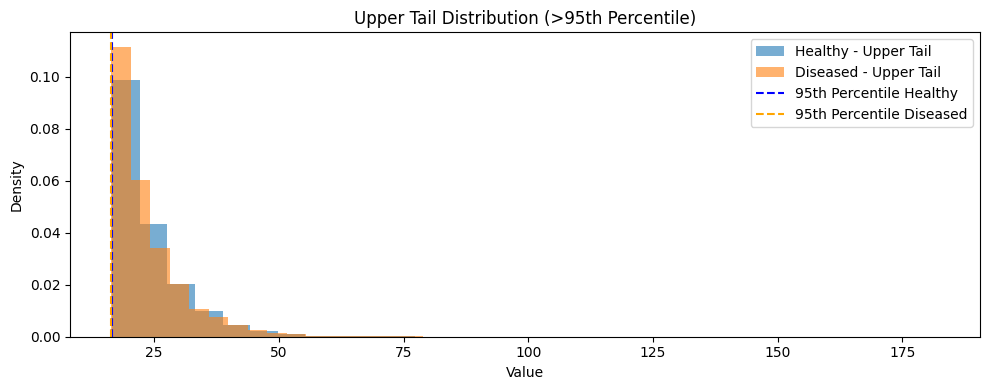

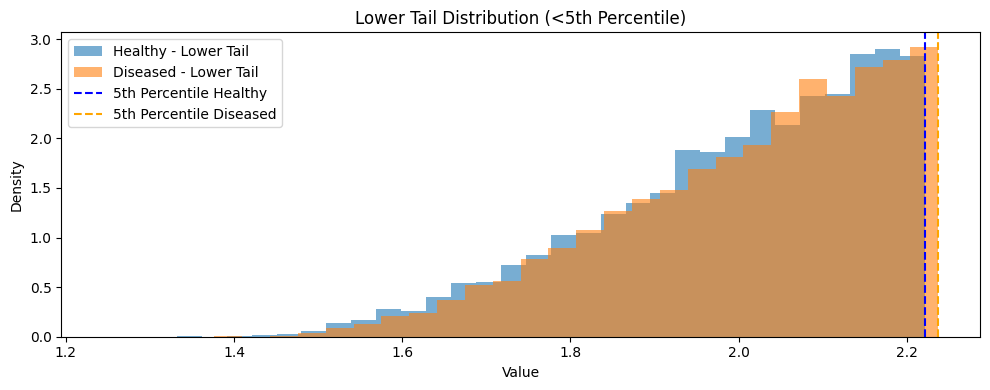

In [4]:
import matplotlib.pyplot as plt

# Plot Upper Tail
plt.figure(figsize=(10, 4))
plt.hist(upper_tail_healthy, bins=30, alpha=0.6, label='Healthy - Upper Tail', density=True)
plt.hist(upper_tail_diseased, bins=30, alpha=0.6, label='Diseased - Upper Tail', density=True)
plt.axvline(q95_healthy, color='blue', linestyle='--', label='95th Percentile Healthy')
plt.axvline(q95_diseased, color='orange', linestyle='--', label='95th Percentile Diseased')
plt.title('Upper Tail Distribution (>95th Percentile)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Lower Tail
plt.figure(figsize=(10, 4))
plt.hist(lower_tail_healthy, bins=30, alpha=0.6, label='Healthy - Lower Tail', density=True)
plt.hist(lower_tail_diseased, bins=30, alpha=0.6, label='Diseased - Lower Tail', density=True)
plt.axvline(q5_healthy, color='blue', linestyle='--', label='5th Percentile Healthy')
plt.axvline(q5_diseased, color='orange', linestyle='--', label='5th Percentile Diseased')
plt.title('Lower Tail Distribution (<5th Percentile)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Calcola i percentile thresholds
q5_healthy, q95_healthy = np.percentile(df_healthy_all['perplexity'], [5, 95])
q5_diseased, q95_diseased = np.percentile(df_diseased_all['perplexity'], [5, 95])

# --- LOWER TAIL ---
lower_tail_healthy_df = df_healthy_all[df_healthy_all['perplexity'] < q5_healthy].copy()
lower_tail_diseased_df = df_diseased_all[df_diseased_all['perplexity'] < q5_diseased].copy()

# --- UPPER TAIL ---
upper_tail_healthy_df = df_healthy_all[df_healthy_all['perplexity'] > q95_healthy].copy()
upper_tail_diseased_df = df_diseased_all[df_diseased_all['perplexity'] > q95_diseased].copy()

# --- SALVA SU CSV ---
lower_tail_healthy_df.to_csv('./tails_analysis/lower_tail_healthy.csv', index=False)
lower_tail_diseased_df.to_csv('./tails_analysis/lower_tail_diseased.csv', index=False)
upper_tail_healthy_df.to_csv('./tails_analysis/upper_tail_healthy.csv', index=False)
upper_tail_diseased_df.to_csv('./tails_analysis/upper_tail_diseased.csv', index=False)

print("✅ CSV salvati:")
print("- lower_tail_healthy.csv")
print("- lower_tail_diseased.csv")
print("- upper_tail_healthy.csv")
print("- upper_tail_diseased.csv")


# Funzione per etichettare la tail
def assign_tail(perplexity, q5, q95):
    if perplexity < q5:
        return 'lower'
    elif perplexity > q95:
        return 'upper'
    else:
        return 'middle'

# Applica la funzione
df_healthy_all['tail'] = df_healthy_all['perplexity'].apply(lambda x: assign_tail(x, q5_healthy, q95_healthy))
df_diseased_all['tail'] = df_diseased_all['perplexity'].apply(lambda x: assign_tail(x, q5_diseased, q95_diseased))

# Salva su CSV
df_healthy_all.to_csv('../tails_analysis/healthy_with_tail_labels.csv', index=False)
df_diseased_all.to_csv('../tails_analysis/diseased_with_tail_labels.csv', index=False)

print("✅ CSV salvati:")
print("- ../tails_analysis/healthy_with_tail_labels.csv")
print("- ../tails_analysis/diseased_with_tail_labels.csv")



✅ CSV salvati:
- lower_tail_healthy.csv
- lower_tail_diseased.csv
- upper_tail_healthy.csv
- upper_tail_diseased.csv


OSError: Cannot save file into a non-existent directory: '../tails_analysis'

## EMBEDDINGS ANALYSIS

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
from evaluate_mlm import main
MODEL_PATH = "/ibmm_data/rodelc/DALM/LM/HEAVY/CDRH3/HEALTHY/P3-pipelines/model/SUB-PIPELINE1:IgG_IgA_Bsources/config3.json_lr5e-5_bs1024/BEST_MODEL/epoch_113/hf"  

In [ ]:
# MODEL_NAME ='H3BERTA_DISEASED_TAILS'
# CSV_FILE = './tails_analysis/diseased_with_tail_labels.csv'
# EMBEDDING_FILE = f"{MODEL_NAME}_embeddings.pkl"
# PCA_OUTPUT_FILE = f"{MODEL_NAME}_pca_output.csv"
# PLOT_TITLE = MODEL_NAME+' PCA embeddings'
# HUE_CLASS = 'tail'
# main(MODEL_NAME, MODEL_PATH, CSV_FILE, EMBEDDING_FILE, PLOT_TITLE, HUE_CLASS, PCA_OUTPUT_FILE, umap=True, pca=True)


In [6]:
# MODEL_NAME ='H3BERTA_HEALTHY_TAILS'
# CSV_FILE = './tails_analysis/healthy_with_tail_labels.csv'
# EMBEDDING_FILE = f"{MODEL_NAME}_embeddings.pkl"
# PCA_OUTPUT_FILE = f"{MODEL_NAME}_pca_output.csv"
# PLOT_TITLE = MODEL_NAME+' PCA embeddings'
# HUE_CLASS = 'tail'
# main(MODEL_NAME, MODEL_PATH, CSV_FILE, EMBEDDING_FILE, PLOT_TITLE, HUE_CLASS, PCA_OUTPUT_FILE, umap=True, pca=True)


# TOO MANY DATA: CREATE A RAPRESENTATIVE SUBSAMPLE
    We first compute the real proportions of lower, middle, and upper tails based on perplexity. Then, we slightly oversample the tails (+5% each) and reduce the middle proportion accordingly, to build a more informative and balanced subset for embedding computation.



In [14]:
def get_adjusted_tail_proportions(df, boost_tail=0.05):
    # Calcola proporzioni originali
    counts = df['tail'].value_counts(normalize=True).to_dict()

    # Sicurezza: assicurati che tutte le classi siano presenti
    for tail in ['lower', 'middle', 'upper']:
        counts.setdefault(tail, 0)

    # Boost tails e penalizza il middle
    lower = counts['lower'] + boost_tail
    upper = counts['upper'] + boost_tail
    middle = 1.0 - (lower + upper)

    # Normalizza se serve
    adjusted = {'lower': lower, 'middle': middle, 'upper': upper}
    total = sum(adjusted.values())
    adjusted = {k: v / total for k, v in adjusted.items()}  # normalize to sum to 1
    return adjusted


def sample_adjusted_subset(df, adjusted_props, n_total=1000000, random_state=42):
    sampled_dfs = []
    for tail, prop in adjusted_props.items():
        n_samples = int(n_total * prop)
        df_tail = df[df['tail'] == tail]
        sampled = df_tail.sample(n=min(n_samples, len(df_tail)), random_state=random_state)
        sampled_dfs.append(sampled)
    return pd.concat(sampled_dfs).sample(frac=1, random_state=random_state)


In [10]:
len(df_healthy_all)

4400181

In [11]:
len(df_diseased_all)

4249699

In [13]:
len(subset_healthy)

999999

In [15]:
# Calcola le proporzioni aggiustate
adjusted_props_healthy = get_adjusted_tail_proportions(df_healthy_all, boost_tail=0.05)
adjusted_props_diseased = get_adjusted_tail_proportions(df_diseased_all, boost_tail=0.05)

print("Proporzioni healthy aggiustate:", adjusted_props_healthy)
print("Proporzioni diseased aggiustate:", adjusted_props_diseased)

# Sample subset
subset_healthy = sample_adjusted_subset(df_healthy_all, adjusted_props_healthy, n_total=1000000)
subset_diseased = sample_adjusted_subset(df_diseased_all, adjusted_props_diseased, n_total=1000000)

# Salva i subset
subset_healthy.to_csv('./tails_analysis/healthy_subset_for_embeddings.csv', index=False)
subset_diseased.to_csv('./tails_analysis/diseased_subset_for_embeddings.csv', index=False)

print("✅ Subset pronti con tails oversampled soft:")
print("- healthy_subset_for_embeddings.csv")
print("- diseased_subset_for_embeddings.csv")


Proporzioni healthy aggiustate: {'lower': 0.09999612515939685, 'middle': 0.8000050225206645, 'upper': 0.09999885231993866}
Proporzioni diseased aggiustate: {'lower': 0.09999859990084004, 'middle': 0.8000013883336208, 'upper': 0.10000001176553916}
✅ Subset pronti con tails oversampled soft:
- healthy_subset_for_embeddings.csv
- diseased_subset_for_embeddings.csv
